**Author**: SERGIO ZAPATA CAPARRÓS

# The dataset consumption. Challenge.

The aim of this challenge is to create a system that extracts data provided by an API, processes it and forms a final dataset through calculations and transformations.

For the development of the challenge, synthetic data will be created as a test to see the performance of the system. Finally, a coherent result will be provided and the execution time will be measured. All the implemented processes are properly explained.

# Table of contents

- [1. Extraction](#extraction) <br>
    - [1.1 Example of a request](#example-of-a-request) <br>
    - [1.2 API response](#api-response) <br>
        - [1.2.1 Dataset construction](#dataset-construction) <br>
        - [1.2.2 Creation of the JSON response](#creation-of-the-json-response) <br>
- [2. Transformation](#transformation) <br>
    - [2.1 From JSON to dataframe](#json-dataframe) <br>
    - [2.2 Uniformity of data](#uniformity-of-data) <br>
    - [2.3 Final dataset structure](#final-dataset) <br>
- [3. Visualization](#visualization) <br>
    

In [27]:
import pandas as pd
import numpy as np
import base64
import json
import os
import io
import matplotlib.pyplot as plt

## <a id='extraction'></a>1. Extraction

The data is extracted by request to an API. The response to this request consists of a JSON which contains a *Base64* encoded CSV file and a "next_page" field to determine the pages to load.

### <a id='example-of-a-request'></a>1.1 Example of a request


It is not required to create the API request, but below I show an example. In this case it is a request to the [API of the INE](https://www.ine.es/dyngs/DataLab/manual.html?cid=45) (Instituto Nacional de Estadística) page.

In [28]:
import requests
from datetime import datetime

In [29]:
ine_code = '39364'
time_init = '20200308'
time_end = '20230308'
language = 'ES'
function = 'DATOS_TABLA' # Or 'DATOS_SERIE' (see https://danielsancheznet.wordpress.com/2020/10/20/extraccion_datos_ine_api/)
api_endpoint = f'https://servicios.ine.es/wstempus/js/{language}/{function}/{ine_code}?date={time_init}:{time_end}'
json_request = requests.get(api_endpoint).json()

In [30]:
json_request[0]
#datetime.fromtimestamp(json_request[0]['Data'][0]['Fecha']/1000).month

{'COD': 'VTE71',
 'Nombre': 'Total Nacional. Viviendas turísticas. Dato base. ',
 'FK_Unidad': 214,
 'FK_Escala': 1,
 'Data': [{'Fecha': 1675206000000,
   'FK_TipoDato': 1,
   'FK_Periodo': 2,
   'Anyo': 2023,
   'Valor': 305136.0,
   'Secreto': False},
  {'Fecha': 1659304800000,
   'FK_TipoDato': 1,
   'FK_Periodo': 8,
   'Anyo': 2022,
   'Valor': 311518.0,
   'Secreto': False},
  {'Fecha': 1643670000000,
   'FK_TipoDato': 1,
   'FK_Periodo': 2,
   'Anyo': 2022,
   'Valor': 285868.0,
   'Secreto': False},
  {'Fecha': 1627768800000,
   'FK_TipoDato': 1,
   'FK_Periodo': 8,
   'Anyo': 2021,
   'Valor': 306974.0,
   'Secreto': False},
  {'Fecha': 1612134000000,
   'FK_TipoDato': 1,
   'FK_Periodo': 2,
   'Anyo': 2021,
   'Valor': 294698.0,
   'Secreto': False},
  {'Fecha': 1596232800000,
   'FK_TipoDato': 1,
   'FK_Periodo': 8,
   'Anyo': 2020,
   'Valor': 321496.0,
   'Secreto': False}]}

The API will return the results in list format containing dictionaries with data, so it is necessary to transform them.

Reference: [INE API Extraction](https://danielsancheznet.wordpress.com/2020/10/20/extraccion_datos_ine_api/).

In [31]:
data_global = pd.DataFrame()
for json in json_request:
    name = json['Nombre']
    month = []
    year = []
    value = []
    period = []
    for info in json['Data']:
        date = datetime.fromtimestamp(info['Fecha']/1000)
        month.append(date.month)
        year.append(date.year)
        value.append(info['Valor'])
        period.append(f'{date.year}M{date.month}')
    
    data_loop = pd.DataFrame({"Month": month, "Year":year, "Value": value, "Period":  period})
    data_loop["Data"] = name
    data_global = pd.concat([data_global, data_loop], ignore_index=True)

data_global['Value'] = data_global['Value'].apply('{:,.0f}'.format).str.replace(',', '.') # Numerical format

In [32]:
data_global.head()

,Month,Year,Value,Period,Data
0,2,2023,305.136,2023M2,Total Nacional. Viviendas turísticas. Dato base.
1,8,2022,311.518,2022M8,Total Nacional. Viviendas turísticas. Dato base.
2,2,2022,285.868,2022M2,Total Nacional. Viviendas turísticas. Dato base.
3,8,2021,306.974,2021M8,Total Nacional. Viviendas turísticas. Dato base.
4,2,2021,294.698,2021M2,Total Nacional. Viviendas turísticas. Dato base.


### <a id='api-response'></a>1.2 API response

It is assumed that there is a method called *retrieve_dataset(data)* which calls the API and returns the appropriate response.

####  <a id='dataset-construction'></a>1.2.1 Dataset construction

Synthetic data has been generated for the csv file from within the API response. The corresponding dataset has the structure shown in the image below. The API supports pagination, so the data must be divided into pages.
<img src="dataset.jpg" alt="dataset" width="60%">
The API returns a CSV file (base64-encoded), with a maximum size of 5GB. This value con be controlled with *rows_page* variable, which determines the number of rows per page, i.e. the extension of a single csv file. An arbitrary test value has been set in this case.

In [63]:
# Defining the rows per page
rows_page = 1000
# Total rows
rows = 50000
# Calculating total pages
if rows % rows_page != 0:
    total_pages = rows // rows_page + 1 # Aditional page
else:
    total_pages = rows // rows_page 
    
# Probabilities are added in order to make data more realistic.
prob_countries = [0.45, 0.05, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.025, 0.025, 0.025, 0.025] # Probability to appearance (countries)
prob_status = [0.4, 0.3, 0.1, 0.025, 0.05, 0.025, 0.025, 0.05, 0.025] # Probability to appearance (status)

# Dataframe with synthetic data
data = {
    'id': np.arange(1, rows + 1), # Unique values for each transaction
    # Assuming 4 countries. Some possible typing errors have been added so they can be corrected in the transformation process.
    'country': np.random.choice(['Spain', 'Germany', 'Italy', 'USA', 'China', 'Belgium', 'Sopain', 'Germqany', 'Itakly', 'United States of America', 'Cvhina', 'Belguiun'], rows, p = prob_countries),
     # Three possible cases. Some possible typing errors have been added so they can be corrected in the transformation process.
    'status': np.random.choice(['pending', 'completed', 'failed', 'pendhing', 'pwnding', 'compoletd', 'complete', 'fialed', 'faoleid'], rows, p = prob_status),
    'amount': np.random.uniform(50, 5000, rows)
}

df = pd.DataFrame(data)
df.head()


,id,country,status,amount
0,1,Spain,fialed,2786.376043
1,2,Spain,completed,3184.444434
2,3,Germany,completed,2533.609704
3,4,Spain,pending,574.906956
4,5,Spain,pending,4338.047167


Now, we slice the dataframe into pages

In [64]:
pages = [] # List
for i in range(0, rows, rows_page): # From 0 to "rows" with step = "rows_page"
    pages.append(df[i:i + rows_page])

#### <a id='creation-of-the-json-response'></a>1.2.2 Creation of the JSON response

A csv is created for each page and encoded in base64. The calculated fields are added to the JSON.

In [65]:
import json
def csv2json(pages, filename, dataset_folder):
    """
    Transforms a paged csv format file into a base64-encoded JSON field.
    
    Parameters:
        pages(list): Dataframe pages
        filename(string): Name of the output file
    """
    json_body = {'pages': []}
    
    for i, page in enumerate(pages):
        # We create a CSV file for each page
        csv_file = os.path.join(dataset_folder, filename + '_page' + str(i+1) + '.csv')
        page.to_csv(csv_file, index = False)
        
        # Read CSV content
        with open(csv_file, 'rb') as f:
            content = f.read()
        
        # Base64 coding
        csv_coded = base64.b64encode(content).decode('utf-8')
        
        page_number = i + 1 # Number of current page
        total_pages = len(pages) # Number of total pages
        
        # Calculating next_page field (0 if last page)
        if(page_number == total_pages):
            next_page = 0
        else:
            next_page = 1
        
        # Adding data to the corresponding dictionary. 'pages' as main field.
        json_body['pages'].append({
            'page_number': page_number,
            'next_page': next_page,
            'csv_data': csv_coded
        })
    
    # Saving dictionary as a JSON
    json_file = filename + '.json'
    with open(json_file, 'w') as f:
        json.dump(json_body, f)
        

# Function call
csv2json(pages, 'transactions', 'dataset/')

# Reading JSON file created previosly (response from the API)
API_response = pd.read_json('transactions.json')
API_response.head()
    

,pages
0,"{'page_number': 1, 'next_page': 1, 'csv_data':..."
1,"{'page_number': 2, 'next_page': 1, 'csv_data':..."
2,"{'page_number': 3, 'next_page': 1, 'csv_data':..."
3,"{'page_number': 4, 'next_page': 1, 'csv_data':..."
4,"{'page_number': 5, 'next_page': 1, 'csv_data':..."


## <a id='transformation'></a>2. Transformation

Once the data is received from the API, it is necessary to transform it and to be able to handle it in an appropriate way. First we must extract the dataset from each CSV file, handle some exceptions and possible errors and, finally, build the final dataset shown in the table below.
<img src="final_dataset.JPG" alt="final_dataset" width="60%">

### <a id='json-dataframe'></a> 2.1 From JSON to dataframe

In [66]:
def decode_csv_from_api(api_response):
    """
    Decodes a base64-encoded CSV file from a JSON.
    
    Parameters:
        api_response (json body): JSON page from API
        
    Returns:
        pandas.dataframe: Data from one csv file
    """
    # Decoding csv file (selecting the corresponding field)
    csv_bytes = base64.b64decode(api_response['csv_data'])
    # Decoded bytes into string
    csv_text = csv_bytes.decode('utf-8')
    # Pandas datafream from csv
    df = pd.read_csv(io.StringIO(csv_text)) # io.StringIO() method to be able to read the file with "pd-read_csv"
    
    return df

def read_from_api(json_file):
    """
    Reads CSV data from a JSON divided into pages.
    
    Parameters:
        json_ile (json file): JSON file rom the API (all pages)
        
    Returns:
        pandas.dataframe: Data from all csv files
    """
    # Loading the corresponding json file
    with open(json_file, 'r') as f:
        json_body = json.load(f)

    csv_data = [] # List
    
    for page in json_body['pages']:
        # Calling the function to decode the csv
        df = decode_csv_from_api(page)
        # Adding decoded data to the list
        csv_data.append(df)
        
        # Check if there is a new page available
        next_page = page.get('next_page') # get() method returns the value associated with the specified key 
        if not next_page:
            break # Leave the loop
    
    # Union of all csv data (all the elements of the list)
    total_df = pd.concat(csv_data, ignore_index=True)
    
    return total_df

df = read_from_api('transactions.json')
# Dataframe with typing errors
df_err = df.copy()
df_err.head()

,id,country,status,amount
0,1,Spain,fialed,2786.376043
1,2,Spain,completed,3184.444434
2,3,Germany,completed,2533.609704
3,4,Spain,pending,574.906956
4,5,Spain,pending,4338.047167


### <a id='uniformity-of-data'></a> 2.2 Uniformity of data

As can be seen, there are typing errors. Uniformity is necessary in order to process the data, so we are going to achieve uniformity.This solution is using a third party library, however, if it is necessary improve error correction, one solution could be to use machine learning classification methods.

In [67]:
# First we replace all "United States of America" for USA
df['country'] = df['country'].replace('United States of America', 'USA')

import difflib

def fix_word(word, options):
    """
    Fixes typing errors found in data. Uses the degree of similarity between a word and another correct word
    
    Parameters:
        word(string): word to compare
        options(list): list of correct words
        
    Returns:
        string: Correct word
    """
    # get_close_matches method returns the closest word (list) of the list. "cutoff" defines the degree of similarity and "n" the number
    # of correct words
    closest = difflib.get_close_matches(word, options, n=1, cutoff=0.7)
    if closest: # If the list isn't empty
        return closest[0]
    else:
        return word
    
correct_countries = ['Spain', 'China', 'USA', 'Italy', 'Belgium', 'Germany'] # List of correct countries
correct_status = ['pending', 'failed', 'completed'] # List of correct status

# With "apply()", we apply lambda function on each value from the corresponding column
df['country'] = df['country'].apply(lambda x: fix_word(x, correct_countries))
df['status'] = df['status'].apply(lambda x: fix_word(x, correct_status))

# Errors has been fixed
df.head()


,id,country,status,amount
0,1,Spain,failed,2786.376043
1,2,Spain,completed,3184.444434
2,3,Germany,completed,2533.609704
3,4,Spain,pending,574.906956
4,5,Spain,pending,4338.047167


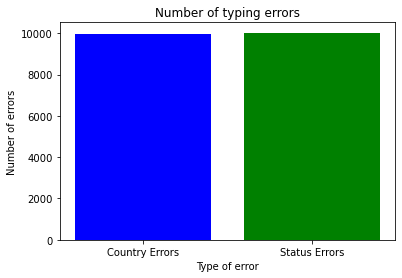

In [68]:
import plotly.express as px

# Number of errors = diferences between both datasets
country_errors = (df_err['country'] != df['country']).sum()
status_errors = (df_err['status'] != df['status']).sum()

# Ploting typing errors
plt.bar(['Country Errors', 'Status Errors'], [country_errors, status_errors], color=['blue', 'green'])
plt.xlabel('Type of error')
plt.ylabel('Number of errors')
plt.title('Number of typing errors')
plt.show()

### <a id='final-dataset'></a> 2.3 Final dataset structure

Once the dataset is prepared, we are going to form the new dataset as shown in the [table](#transformation). Firstly, we need to agregate by country.
In order to build the new dataset, the following reference has been used: [Pandas & SQL](https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_sql.html)

Calculation of "average_outstanding" and "total_completed" fields.

In [69]:
# First, the "pending" filter is applied, grouped by country and the average amount is calculated.
average_outstanding = df[df['status'] == 'pending'].groupby('country')['amount'].mean()
# First, the "completed" filter is applied, grouped by country and the total amount is calculated.
total_completed = df[df['status'] == 'completed'].groupby('country')['amount'].sum()

Calculation of "error_rate" and "critical_rate" fields. 

*Note: critical_rate will be always 0 due to any transaction is above 1M dollars*

In [70]:
# The "failed" filter is applied, grouped by country and counting appearances. Divided by appearances
error_rate = df[df['status'] == 'failed'].groupby('country').size() / df.groupby('country').size()
# Two filters are applied: One for amounts above 10000 and the other for failed transactions. Grouped by country and counting appearances.
critical_rate = df[(df['amount'] > 1000000) & (df['status'] == 'failed')].groupby('country').size() / df.groupby('country').size()
# Filling NaN values with zeros.
critical_rate = critical_rate.fillna(0)

Finally, we build the demanding dataset.

In [71]:
# Constructing the dataset from a dictionary
final_df = pd.DataFrame({
    'country': average_outstanding.index,
    'average_outstanding': average_outstanding.values,
    'total_completed': total_completed.values,
    'critical_rate': critical_rate.values,  # Llenar los valores NaN con 0
    'error_rate': error_rate.values
})

final_df.head()

,country,average_outstanding,total_completed,critical_rate,error_rate
0,Belgium,2560.736440,3.420667e+06,0.0,0.169338
1,China,2466.425719,3.309252e+06,0.0,0.178950
2,Germany,2548.209959,4.226074e+06,0.0,0.171731
3,Italy,2499.150699,5.576065e+06,0.0,0.183011
4,Spain,2543.299228,2.178166e+07,0.0,0.173978


## <a id='visualization'></a>3. Visualization

For data visualization, the following reference has been used: [Plotly](https://plotly.com/python/plotly-express/)

In [72]:
import plotly.express as px

data = {
    'Country': final_df['country'],
    'Average Amount of Pending Transactions': final_df['average_outstanding']
}
df_plot = pd.DataFrame(data)
fig = px.bar(df_plot, x='Country', y='Average Amount of Pending Transactions', title='Average Amount of Pending Transactions per Country', color='Country')
fig.show()


In [73]:
import plotly.graph_objects as go

# Sorting countries by error rate
final_df_sorted = final_df.sort_values(by = 'error_rate', ascending=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=final_df_sorted['country'],
    x=final_df_sorted['error_rate'],
    orientation='h',
    name='Error Rate',
    hovertemplate ='%{y}:<br>Error Rate: %{x:.2f}%<br>Total Transactions: %{customdata}',  # Text when hover
    customdata = final_df_sorted['total_completed']  # Adding total transactions to hover
))

fig.update_layout(
    title='Top countries with highest error rate',
    xaxis_title='Error rate',
    yaxis_title='Country'
)

fig.show()
